# Megaline Mobile Phone Plan Analysis

## Project description
### Briefing
I assume the role of an analyst at Megaline, a mobile network operator. Megaline provides customers with two prepaid package options, Surf and Ultimate. The marketing department wishes to know which package provides the company with more income in order to make adjustments to the advertising budget.

The company has provided me with the data of 500 Megaline clients, consisting of their personal information, choice of package, and usage of the service in 2018. I will analyze the clients' behavior to determine which package brings in more profit.

### Package information
Information specified below is for a one-month period. <br>
Megaline rounds call durations upwards to the nearest minute. Total monthly data usage is rounded to the next gigabyte.

**Surf**
1. Fee: \$20
1. 500 minutes of phone calls, 50 SMS, 15 GB of data
1. Additional charges after reaching the usage limit:
    1. 3 cents per minute
    1. 3 cents per SMS
    1. $10 per 1 GB of data
    
**Ultimate**
1. Fee: \$70
1. 3000 minutes of phone calls, 1000 SMS, 30 GB of data
1. Additional charges after reaching the usage limit:
    1. 1 cent per minute
    1. 1 cent per SMS
    1. $7 per 1 GB of data
    
### Data description
`users`:  users' personal information.
- `user_id`
- `first_name`
- `last_name`
- `age`: in years
- `reg_date`: date of registration (in dd, mm, yy)
- `churn_date`: date of churning. Null or missing if user was still using the service by the time of data creation
- `city`
- `plan`

`calls`: information on phone calls. 
- `id`: call ID
- `call_date`
- `duration`: in minutes
- `user_id`: the ID of the user who started the call

`messages`: information on SMS.
- `id`
- `message_date`: date of sending
- `user_id`

`internet`: information on data usage per web session.
- `id`: unique web session ID
- `mb_used`: data used in the session, in megabytes
- `session_date`
- `user_id`

`plans`: information on mobile plans.
- `plan_name`
- `usd_monthly_fee`
- `minutes_inculded`: allocation of calls per month, in minutes
- `messages_included`: allocation of SMS per month
- `mb_per_month_included`: allocation of data per month, in megabytes
- `usd_per_minute`: extra charge per minute outside of allocated call time
- `usd_per_message`: extra charge per SMS outside of allocated messages
- `usd_per_gb`: extra charge per gygabites of data usage outside of allocated data (1 GB = 1024 MB)

## Objective
Determining which plan package is more profitable.

## Hypotheses
1. Ultimate and Surf packages generate different mean income.
1. The mean income gathered from NY-NJ differ from the mean from other regions.


## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

## Loading the datasets

In [2]:
users = pd.read_csv('megaline_users.csv')
calls = pd.read_csv('megaline_calls.csv')
messages = pd.read_csv('megaline_messages.csv')
internet = pd.read_csv('megaline_internet.csv')
plans = pd.read_csv('megaline_plans.csv')

## Data preprocessing

### Checking the datasets

#### `users`

In [3]:
users.info()
print()
print('Null values: ')
print(users.isnull().sum())
print()
print('Duplicates: ')
print(users[users.duplicated()].count())
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB

Null values: 
user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64

Duplicates: 
user_id       0
first_name    0
last_name     0
age           0
city          0
reg_date      0
plan          0
churn_date    0
dtype: int64


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


#### `calls`

In [4]:
calls.info()
print()
print('Null values: ')
print(calls.isnull().sum())
print()
print('Duplicates: ')
print(calls[calls.duplicated()].count())
print()
print('Five-number summary:')
print(calls['duration'].describe())
calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

Null values: 
id           0
user_id      0
call_date    0
duration     0
dtype: int64

Duplicates: 
id           0
user_id      0
call_date    0
duration     0
dtype: int64

Five-number summary:
count    137735.000000
mean          6.745927
std           5.839241
min           0.000000
25%           1.290000
50%           5.980000
75%          10.690000
max          37.600000
Name: duration, dtype: float64


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


In [5]:
calls[calls['duration'] == 0]

,id,user_id,call_date,duration
19,1001_4,1001,2018-12-05,0.0
25,1001_13,1001,2018-12-24,0.0
31,1001_30,1001,2018-10-17,0.0
32,1001_31,1001,2018-11-03,0.0
34,1001_35,1001,2018-12-21,0.0
...,...,...,...,...
137714,1499_183,1499,2018-11-10,0.0
137715,1499_184,1499,2018-09-15,0.0
137720,1499_189,1499,2018-12-27,0.0
137722,1499_191,1499,2018-12-24,0.0


#### `messages`

In [6]:
messages.info()
print()
print('Null values: ')
print(messages.isnull().sum())
print()
print('Duplicates: ')
print(messages[messages.duplicated()].count())
print()
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB

Null values: 
id              0
user_id         0
message_date    0
dtype: int64

Duplicates: 
id              0
user_id         0
message_date    0
dtype: int64



,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24


#### `internet`

In [7]:
internet.info()
print()
print('Null values: ')
print(internet.isnull().sum())
print()
print('Duplicates: ')
print(internet[internet.duplicated()].count())
print()
print('Five-number summary:')
print(internet['mb_used'].describe())
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB

Null values: 
id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

Duplicates: 
id              0
user_id         0
session_date    0
mb_used         0
dtype: int64

Five-number summary:
count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00


In [8]:
internet[internet['mb_used'] == 0]

,id,user_id,session_date,mb_used
1,1000_204,1000,2018-12-31,0.0
14,1001_26,1001,2018-09-17,0.0
16,1001_28,1001,2018-10-17,0.0
34,1001_54,1001,2018-09-02,0.0
43,1001_77,1001,2018-10-31,0.0
...,...,...,...,...
104797,1499_192,1499,2018-09-19,0.0
104804,1499_199,1499,2018-12-09,0.0
104816,1499_211,1499,2018-09-26,0.0
104817,1499_212,1499,2018-09-11,0.0


In [9]:
plans.info()
plans

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Things to note:
- redundant data:
    - columns containing dates have unused information (dates, as opposed to months).
    - `city` contains unnecessary details on administrative divisions.    
    
- incorrect data types:
	- `user_id` is in `int64` can be converted to `object`.
	- columns containing dates can be converted to `datetime`.

- unspecified missing values:
    - `calls` and `internet` datasets have entries in their measuring columns with `0.0` in value. <br> These can be ignored since they won't be rounded up and interfere with calculating the extra costs.

### Data cleaning & feature engineering

#### Dates
Since individual days are not relevant in this project, columns containing dates can be converted to only specify a one-month period. 

In [10]:
# Defining the function to convert dates to month periods
def to_month(dataset, column):
    """
    This function takes a column from a dataset,
    converts it to `datetime` type, and 
    once again to `period` type of one month.
    Returns a series.
    """
    months = pd.to_datetime(dataset[column])
    months = months.dt.to_period('M')
    return months

# Converting columns with dates to `period` data types
## `users`
users['reg_month'] = to_month(users, 'reg_date')
users['churn_month'] = to_month(users, 'churn_date')

## `calls`
calls['month'] = to_month(calls, 'call_date')

## `messages`
messages['month'] = to_month(messages, 'message_date')

## `internet`
internet['month'] = to_month(internet, 'session_date')

#### `user_id` data type
`user_id` can be converted to string `object`.

In [11]:
# Converting `user_id` from `int64` to `object`
users['user_id'] = users['user_id'].astype('object')
calls['user_id'] = calls['user_id'].astype('object')
messages['user_id'] = messages['user_id'].astype('object')
internet['user_id'] = internet['user_id'].astype('object')

#### Removing unnecessary information in `city` and flagging
Hypothesis testing requires no details about the administrative units other than the major city/state, so entries in `city` (in `users`) can be split to exclude the unnecessary information. They can also be flagged to simplify later analyses as required by the hypothesis.

Calling the method `unique` on the `city` column shows that the required administrative units are placed between `..., ` and ` MSA`.

In [12]:
users['city'].unique()

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [13]:
# Extracting the required info from `users['city']`
users['clean_city'] = users['city'].str.split(', ').str[1]
users['clean_city'] = users['clean_city'].str.replace(' MSA', '')

In [14]:
# Flagging values with `NY-NJ`
users['is_ny_nj'] = users['clean_city'].str.contains('NY-NJ', regex=True)

#### Usage count & rounding
SMS usage per month can be counted by aggregating the data.

In [15]:
messages_user_month = pd.pivot_table(data=messages, index=['user_id', 'month'], values='id', aggfunc='count')
messages_user_month.rename(columns={'id': 'message_count'}, inplace=True)
messages_user_month

message_count
user_id month                 
1000    2018-12             11
1001    2018-08             30
        2018-09             44
        2018-10             53
        2018-11             36
...                        ...
1496    2018-09             21
        2018-10             18
        2018-11             13
        2018-12             11
1497    2018-12             50

[1806 rows x 1 columns]

Megaline rounds phone calls upwards to the next minute and the monthly total of internet usage to the next gigabyte. Rounding these values now can ease further calculations.

In [16]:
# Rounding phone call duration
calls['call_duration'] = np.ceil(calls['duration'])

# Aggregating call duration per month
calls_user_month = pd.pivot_table(data=calls, index=['user_id', 'month'], values='call_duration', aggfunc='sum')
calls_user_month

call_duration
user_id month                 
1000    2018-12          124.0
1001    2018-08          182.0
        2018-09          315.0
        2018-10          393.0
        2018-11          426.0
...                        ...
1498    2018-12          339.0
1499    2018-09          346.0
        2018-10          385.0
        2018-11          308.0
        2018-12          496.0

[2258 rows x 1 columns]

In [17]:
# Aggregating internet usage data by user and month
internet_user_month = pd.pivot_table(data=internet, index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_user_month

mb_used
user_id month            
1000    2018-12   1901.47
1001    2018-08   6919.15
        2018-09  13314.82
        2018-10  22330.49
        2018-11  18504.30
...                   ...
1498    2018-12  23137.69
1499    2018-09  12984.76
        2018-10  19492.43
        2018-11  16813.83
        2018-12  22059.21

[2277 rows x 1 columns]

In [18]:
# Rounding up internet usage to the next GB
internet_user_month['gb_used'] = np.ceil(internet_user_month['mb_used'] / 1024) 
internet_user_month

mb_used  gb_used
user_id month                     
1000    2018-12   1901.47      2.0
1001    2018-08   6919.15      7.0
        2018-09  13314.82     14.0
        2018-10  22330.49     22.0
        2018-11  18504.30     19.0
...                   ...      ...
1498    2018-12  23137.69     23.0
1499    2018-09  12984.76     13.0
        2018-10  19492.43     20.0
        2018-11  16813.83     17.0
        2018-12  22059.21     22.0

[2277 rows x 2 columns]

Similarly, the unit of data measurement in `plans` can be converted to gigabytes.

In [19]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15.0
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30.0


#### Aggregating relevant data
All data relevant to the analysis can now be put together in a single, new dataframe.

In [20]:
# Preparing user ID values for cross-joining
temp_df = pd.DataFrame(users['user_id'].unique())
user_id_list = temp_df
user_id_list.columns = ['user_id']
user_id_list['key'] = 1
user_id_list

,user_id,key
0,1000,1
1,1001,1
2,1002,1
3,1003,1
4,1004,1
...,...,...
495,1495,1
496,1496,1
497,1497,1
498,1498,1


In [21]:
# Preparing month values for cross-joining
temp_df = calls_user_month.reset_index()
months = pd.DataFrame(temp_df['month'].unique())
months.columns = ['month']
months.sort_values(by='month', ascending=True, inplace=True)
months['key'] = 1
months

,month,key
10,2018-01,1
11,2018-02,1
8,2018-03,1
9,2018-04,1
5,2018-05,1
6,2018-06,1
7,2018-07,1
1,2018-08,1
2,2018-09,1
3,2018-10,1


In [22]:
# Cross-joining user ID and months
data = user_id_list.merge(months, on='key', how='inner')
data.drop('key', axis=1, inplace=True)
data

,user_id,month
0,1000,2018-01
1,1000,2018-02
2,1000,2018-03
3,1000,2018-04
4,1000,2018-05
...,...,...
5995,1499,2018-08
5996,1499,2018-09
5997,1499,2018-10
5998,1499,2018-11


In [23]:
# Merging datasets

## `users`
temp_df = users[['user_id', 'age', 'plan', 'reg_month', 'churn_month', 'clean_city', 'is_ny_nj']]
data = data.merge(temp_df, on='user_id', how='left')

## `calls_user_month`
data = data.merge(calls_user_month, on=['user_id', 'month'], how='left')

## `messages_user_month`
data = data.merge(messages_user_month, on=['user_id', 'month'], how='left')

## `internet_user_month`
temp_df = internet_user_month[['gb_used']]
data = data.merge(temp_df, on=['user_id', 'month'], how='left')

data

,user_id,month,age,plan,reg_month,churn_month,clean_city,is_ny_nj,call_duration,message_count,gb_used
0,1000,2018-01,45,ultimate,2018-12,NaT,GA,False,NaN,NaN,NaN
1,1000,2018-02,45,ultimate,2018-12,NaT,GA,False,NaN,NaN,NaN
2,1000,2018-03,45,ultimate,2018-12,NaT,GA,False,NaN,NaN,NaN
3,1000,2018-04,45,ultimate,2018-12,NaT,GA,False,NaN,NaN,NaN
4,1000,2018-05,45,ultimate,2018-12,NaT,GA,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5995,1499,2018-08,37,surf,2018-05,NaT,FL,False,NaN,NaN,NaN
5996,1499,2018-09,37,surf,2018-05,NaT,FL,False,346.0,NaN,13.0
5997,1499,2018-10,37,surf,2018-05,NaT,FL,False,385.0,NaN,20.0
5998,1499,2018-11,37,surf,2018-05,NaT,FL,False,308.0,NaN,17.0


#### Removing empty rows
Due to the `data`frame being indexed by `user_id` and `month`, some users that hadn't registered on that month have `NaN` values across all of their usage variables. These empty rows will be dropped.

In [24]:
data = data.loc[(data['month'] >= data['reg_month']) &
                ((data['month'] <= data['churn_month']) | (data['churn_month'].isnull() == True))].reset_index()

data

,index,user_id,month,age,plan,reg_month,churn_month,clean_city,is_ny_nj,call_duration,message_count,gb_used
0,11,1000,2018-12,45,ultimate,2018-12,NaT,GA,False,124.0,11.0,2.0
1,19,1001,2018-08,28,surf,2018-08,NaT,WA,False,182.0,30.0,7.0
2,20,1001,2018-09,28,surf,2018-08,NaT,WA,False,315.0,44.0,14.0
3,21,1001,2018-10,28,surf,2018-08,NaT,WA,False,393.0,53.0,22.0
4,22,1001,2018-11,28,surf,2018-08,NaT,WA,False,426.0,36.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3308,5995,1499,2018-08,37,surf,2018-05,NaT,FL,False,NaN,NaN,NaN
3309,5996,1499,2018-09,37,surf,2018-05,NaT,FL,False,346.0,NaN,13.0
3310,5997,1499,2018-10,37,surf,2018-05,NaT,FL,False,385.0,NaN,20.0
3311,5998,1499,2018-11,37,surf,2018-05,NaT,FL,False,308.0,NaN,17.0


In [25]:
data.loc[(data['call_duration'].isna() == True) &
         (data['message_count'].isna() == True) &
         (data['gb_used'].isna() == True)]

,index,user_id,month,age,plan,reg_month,churn_month,clean_city,is_ny_nj,call_duration,message_count,gb_used
9,36,1003,2018-01,52,surf,2018-01,NaT,OK,False,NaN,NaN,NaN
10,37,1003,2018-02,52,surf,2018-01,NaT,OK,False,NaN,NaN,NaN
11,38,1003,2018-03,52,surf,2018-01,NaT,OK,False,NaN,NaN,NaN
12,39,1003,2018-04,52,surf,2018-01,NaT,OK,False,NaN,NaN,NaN
13,40,1003,2018-05,52,surf,2018-01,NaT,OK,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3287,5958,1496,2018-07,49,surf,2018-02,NaT,LA,False,NaN,NaN,NaN
3305,5992,1499,2018-05,37,surf,2018-05,NaT,FL,False,NaN,NaN,NaN
3306,5993,1499,2018-06,37,surf,2018-05,NaT,FL,False,NaN,NaN,NaN
3307,5994,1499,2018-07,37,surf,2018-05,NaT,FL,False,NaN,NaN,NaN


There is also a large number of rows (1057, ~32%) containing null values in every service type, even though the month is on the exact or later date than the registration time. These missing values do not interfere with any calculations, so they will be kept.

#### Calculating extra charges
Now that the calls, SMS, and internet data have been aggregated per month, it is possible to calculate the extra costs.

In [26]:
def extra_cost(service, usage, plan):
    """
    This function calculates the extra costs for service usage 
    outside of pre-allocated plan limits.
    
    Parameters:
    service = type of service used
    usage = amount of service used
    plan = mobile plan that the user subscribed to
    
    The function will return 0 if it detects no usage.
    Else, it will get the plan's limit of the corresponding service
    and compares it to the current usage.
    If usage does not exceed the plan limit, it will return 0 in extra costs.
    If usage exceeds the plan limit,
    it will return the extra costs,
    calculated by multiplying extra usage by extra costs per usage unit
    of the corresponding plan.
    """
    if np.isnan(usage):
        return 0
    
    elif plan == 'surf':
        if service == 'call':
            limit = plans.loc[0, 'minutes_included']
            
            if (usage - limit) <= 0:
                return 0
            else:
                return (usage - limit) * plans.loc[0, 'usd_per_minute']
            
        elif service == 'message':
            limit = plans.loc[0, 'messages_included']
            
            if (usage - limit) <= 0:
                return 0
            else:
                return (usage - limit) * plans.loc[0, 'usd_per_message']
            
        elif service == 'internet':
            limit = plans.loc[0, 'gb_per_month_included']
            
            if (usage - limit) <= 0:
                return 0
            else:
                return (usage - limit) * plans.loc[0, 'usd_per_gb']
            
    elif plan == 'ultimate':
        if service == 'call':
            limit = plans.loc[1, 'minutes_included']
            
            if (usage - limit) <= 0:
                return 0
            else:
                return (usage - limit) * plans.loc[1, 'usd_per_minute']
            
        elif service == 'message':
            limit = plans.loc[0, 'messages_included']
            
            if (usage - limit) <= 0:
                return 0
            else:
                return (usage - limit) * plans.loc[1, 'usd_per_message']
            
        elif service == 'internet':
            limit = plans.loc[0, 'gb_per_month_included']
            
            if (usage - limit) <= 0:
                return 0
            else:
                return (usage - limit) * plans.loc[1, 'usd_per_gb']

In [27]:
# Calculating extra costs for calls
data['extra_call_cost'] = data.apply(
    (lambda row: extra_cost(service = 'call', 
                            usage = row['call_duration'], 
                            plan = row['plan'])
    ), 
    axis=1
)

# Calculating extra costs for messages
data['extra_message_cost'] = data.apply(
    (lambda row: extra_cost(service = 'message', 
                            usage = row['message_count'], 
                            plan = row['plan'])
    ), 
    axis=1
)

# Calculating extra costs for internet usage
data['extra_internet_cost'] = data.apply(
    (lambda row: extra_cost(service = 'internet', 
                            usage = row['gb_used'], 
                            plan = row['plan'])
    ), 
    axis=1
)

data

,index,user_id,month,age,plan,reg_month,churn_month,clean_city,is_ny_nj,call_duration,message_count,gb_used,extra_call_cost,extra_message_cost,extra_internet_cost
0,11,1000,2018-12,45,ultimate,2018-12,NaT,GA,False,124.0,11.0,2.0,0.0,0.00,0.0
1,19,1001,2018-08,28,surf,2018-08,NaT,WA,False,182.0,30.0,7.0,0.0,0.00,0.0
2,20,1001,2018-09,28,surf,2018-08,NaT,WA,False,315.0,44.0,14.0,0.0,0.00,0.0
3,21,1001,2018-10,28,surf,2018-08,NaT,WA,False,393.0,53.0,22.0,0.0,0.09,70.0
4,22,1001,2018-11,28,surf,2018-08,NaT,WA,False,426.0,36.0,19.0,0.0,0.00,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,5995,1499,2018-08,37,surf,2018-05,NaT,FL,False,NaN,NaN,NaN,0.0,0.00,0.0
3309,5996,1499,2018-09,37,surf,2018-05,NaT,FL,False,346.0,NaN,13.0,0.0,0.00,0.0
3310,5997,1499,2018-10,37,surf,2018-05,NaT,FL,False,385.0,NaN,20.0,0.0,0.00,50.0
3311,5998,1499,2018-11,37,surf,2018-05,NaT,FL,False,308.0,NaN,17.0,0.0,0.00,20.0


#### Summary of changes
1. Conversion of dates into months as `period`-type data.
1. Conversion of `user_id` into string `object`s.
1. Removal of unnecessary `city` details and flagging of `NY-NJ` entries for later use.
1. Aggregation and rounding of service usage by month. Call seconds were rounded to the next minute and data units have been changed to gigabytes.
1. Aggregation of all relevant data into a single dataframe called `data`.
1. Removal of empty rows.
1. Calculation of extra charges incurred by service usage outside of plan allocation.

### EDA & hypothesis testing
**Objective**: determining which mobile plan brings in more income.

**Questions**:
1. How was each service usage distributed by month?
1. How much income did each plan bring in 2018?
1. How much did extra charges contribute to the income?
1. How is the mean monthly income in NY-NJ regions compared to those of other regions?

**Hypotheses**:
1. The mean income obtained from Surf and Ultimate users are different.
1. The mean income obtained from users in NY-NJ is different from the mean income obtained from users of others regions.

#### 1. Monthly service usage distribution

To see the distribution of monthly service usage, the data can be aggregated by their time of use.

In [28]:
# Calls
calls_by_month = pd.pivot_table(data=data, index=['plan', 'month'], values='call_duration', aggfunc='sum')
calls_by_month = calls_by_month.reset_index()
calls_user_month = data[['plan', 'month', 'user_id', 'call_duration']]
print(calls_by_month.describe())
calls_by_month

       call_duration
count      24.000000
mean    40347.333333
std     39346.381124
min       406.000000
25%      7461.000000
50%     29996.000000
75%     58252.500000
max    144600.000000


,plan,month,call_duration
0,surf,2018-01,406.0
1,surf,2018-02,2673.0
2,surf,2018-03,7590.0
3,surf,2018-04,17577.0
4,surf,2018-05,30768.0
5,surf,2018-06,41836.0
6,surf,2018-07,54448.0
7,surf,2018-08,66438.0
8,surf,2018-09,80360.0
9,surf,2018-10,99903.0


In [29]:
# SMS
messages_by_month = pd.pivot_table(data=data, index=['plan', 'month'], values='message_count', aggfunc='sum')
messages_by_month = messages_by_month.reset_index()
messages_user_month = data[['plan', 'month', 'user_id', 'message_count']]
print(messages_by_month.describe())
messages_by_month

       message_count
count      24.000000
mean     3121.750000
std      3196.631614
min        21.000000
25%       435.000000
50%      2195.500000
75%      4712.000000
max     11766.000000


,plan,month,message_count
0,surf,2018-01,21.0
1,surf,2018-02,108.0
2,surf,2018-03,351.0
3,surf,2018-04,870.0
4,surf,2018-05,1849.0
5,surf,2018-06,2454.0
6,surf,2018-07,3271.0
7,surf,2018-08,4662.0
8,surf,2018-09,5968.0
9,surf,2018-10,7848.0


In [30]:
# Internet
internet_by_month = pd.pivot_table(data=data, index=['plan', 'month'], values='gb_used', aggfunc='sum')
internet_by_month = internet_by_month.reset_index()
internet_user_month = data[['plan', 'month', 'user_id', 'gb_used']]
print(internet_by_month.describe())
internet_by_month

           gb_used
count    24.000000
mean   1586.708333
std    1538.055364
min      10.000000
25%     335.250000
50%    1168.000000
75%    2271.500000
max    5559.000000


,plan,month,gb_used
0,surf,2018-01,10.0
1,surf,2018-02,110.0
2,surf,2018-03,312.0
3,surf,2018-04,611.0
4,surf,2018-05,1087.0
5,surf,2018-06,1502.0
6,surf,2018-07,2042.0
7,surf,2018-08,2735.0
8,surf,2018-09,3238.0
9,surf,2018-10,4058.0


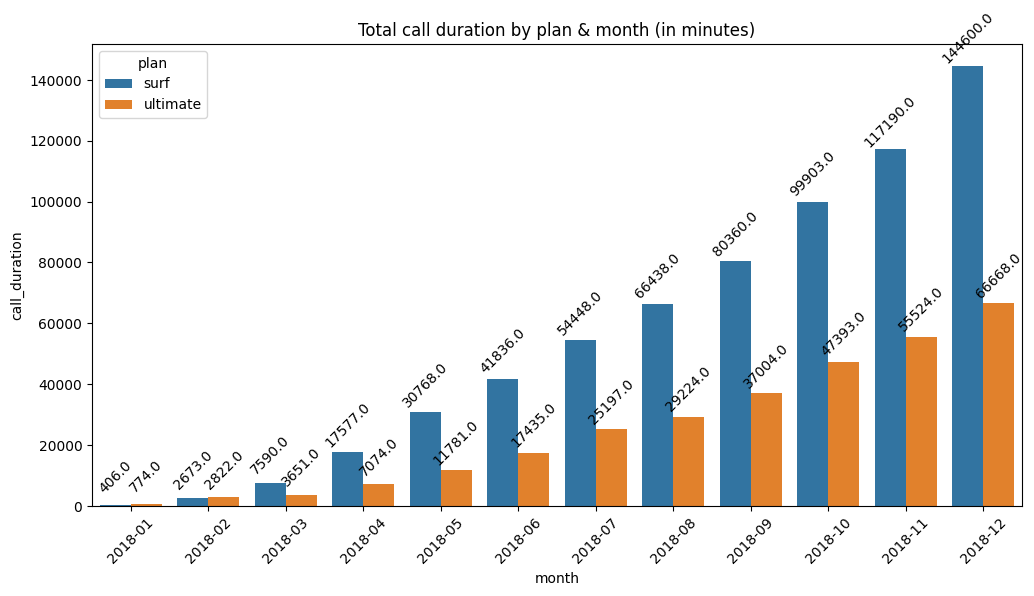

In [31]:
# Data visualization
## Calls
plt.figure(figsize=(12, 6))
splot = sns.barplot(data=calls_by_month, x='month', y='call_duration', hue='plan')
plt.title('Total call duration by plan & month (in minutes)')

### Annotating bars
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.1f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 20), rotation=45, 
                   textcoords = 'offset points')
    

plt.xticks(rotation = 45)
plt.show()

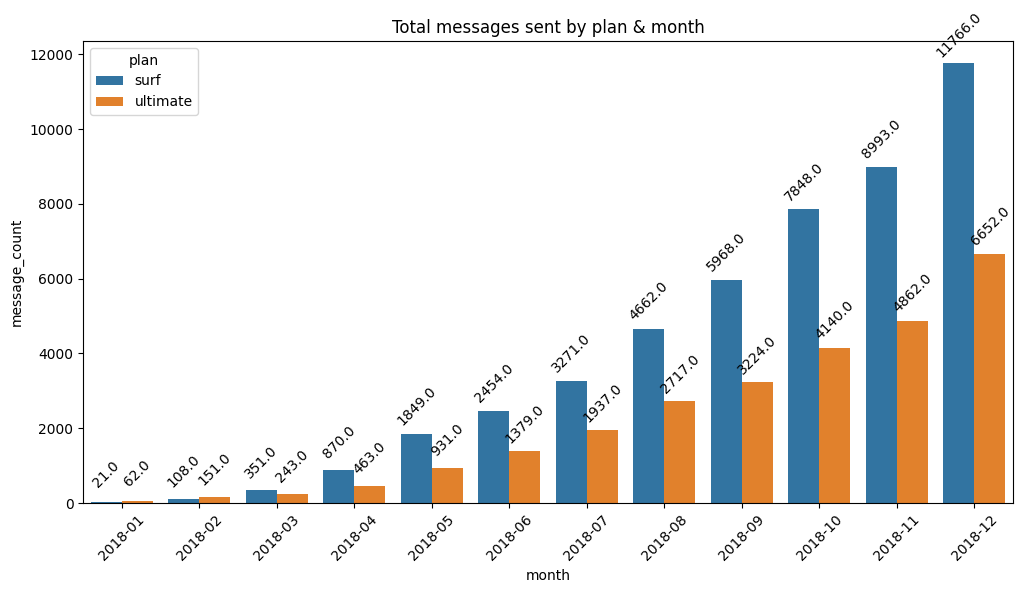

In [32]:
## Messages
plt.figure(figsize=(12, 6))
splot = sns.barplot(data=messages_by_month, x='month', y='message_count', hue='plan')
plt.title('Total messages sent by plan & month')

### Annotating bars
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.1f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 20), rotation=45, 
                   textcoords = 'offset points')
    

plt.xticks(rotation = 45)
plt.show()

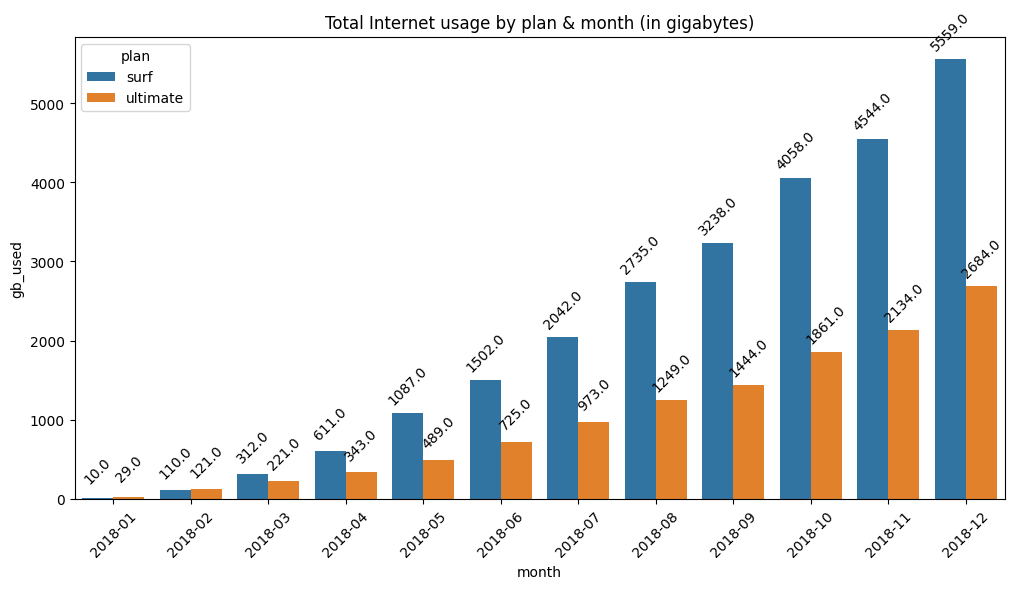

In [33]:
## Internet
plt.figure(figsize=(12, 6))
splot = sns.barplot(data=internet_by_month, x='month', y='gb_used', hue='plan')
plt.title('Total Internet usage by plan & month (in gigabytes)')

### Annotating bars
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.1f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 20), rotation=45, 
                   textcoords = 'offset points')
    

plt.xticks(rotation = 45)
plt.show()

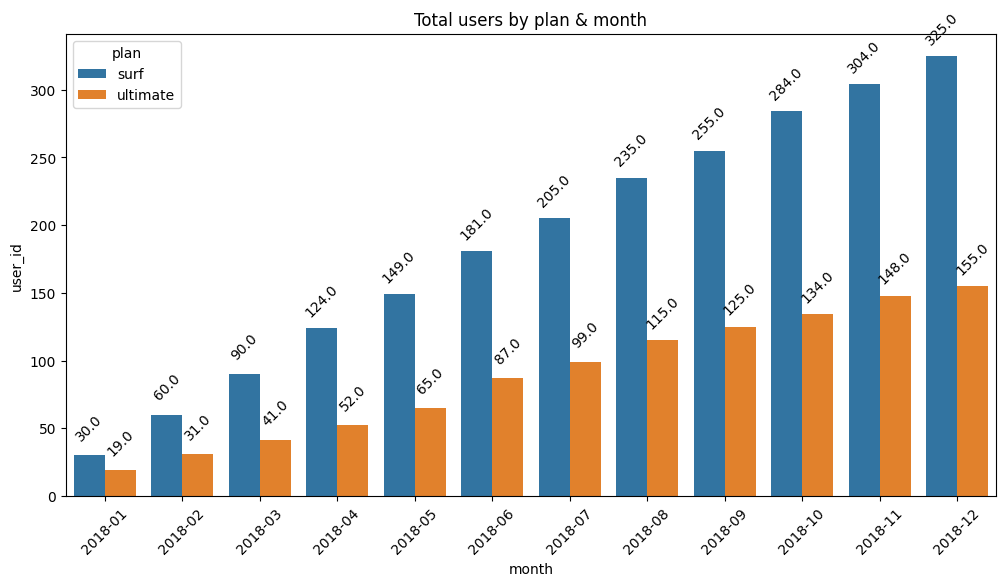

In [34]:
# Showing the number of registered users by plan and time of year
num_users = pd.pivot_table(data=data, index=['plan', 'month'], values='user_id', aggfunc='count')
num_users = num_users.reset_index()

plt.figure(figsize=(12, 6))
splot = sns.barplot(data=num_users, x='month', y='user_id', hue='plan')
plt.title('Total users by plan & month')

### Annotating bars
for g in splot.patches:
    splot.annotate(format(g.get_height(), '.1f'),
                   (g.get_x() + g.get_width() / 2., g.get_height()),
                   ha = 'center', va = 'center', 
                   xytext = (0, 20), rotation=45, 
                   textcoords = 'offset points')
    

plt.xticks(rotation = 45)
plt.show()

In [35]:
num_users = num_users.reset_index()
num_users.loc[(num_users['month'] == '2018-01') |
              (num_users['month'] == '2018-06') | 
              (num_users['month'] == '2018-12')
             ]

,index,plan,month,user_id
0,0,surf,2018-01,30
5,5,surf,2018-06,181
11,11,surf,2018-12,325
12,12,ultimate,2018-01,19
17,17,ultimate,2018-06,87
23,23,ultimate,2018-12,155


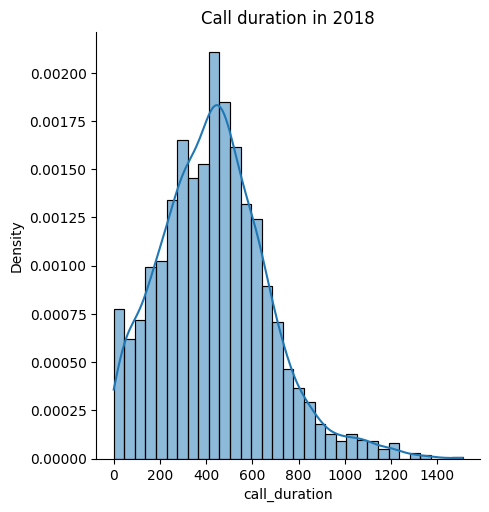

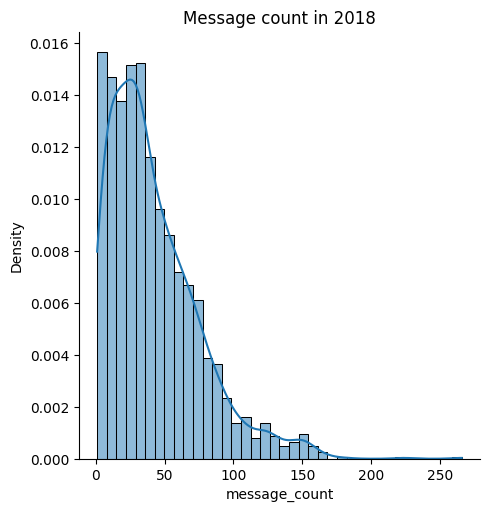

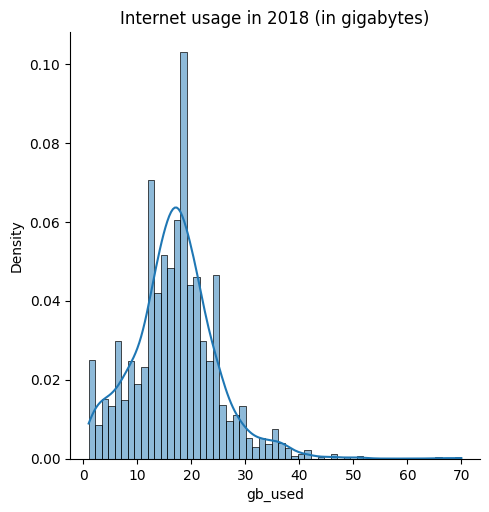

In [36]:
# Year-round usage visualization
sns.displot(data=calls_user_month, x='call_duration', stat='density', kde=True)
plt.title('Call duration in 2018')

sns.displot(data=messages_user_month, x='message_count', stat='density', kde=True)
plt.title('Message count in 2018')

sns.displot(data=internet_user_month, x='gb_used', stat='density', kde=True)
plt.title('Internet usage in 2018 (in gigabytes)')

plt.show()

**Findings & insights:**
As shown by the charts and descriptions above, one same trend applies to all 3 services in both packages: total usage of all users steadily increased as the year progressed, meaning the least amount of usage was recorded in January and the most in December. This trend also applies to the number of registered users, which seems to be the cause of the rise in usage.

The density histograms show that, in a year, it was likely for the average user to spend around 500 minutes on calls, less than 50 messages, and about 20 gigabytes of data.

It is also worth noting that there were always more Surf users than Ultimate users.

#### 2. Income by plan & 3. Contribution of extra charges

Income can be calculated by multiplying the number of users by the plan price and adding in extra costs. Extra charges simply need to be aggregated from the main dataframe.

In [37]:
# Aggregating data for revenue calculation
income_by_user = data[['user_id', 'is_ny_nj', 'plan', 'month', 
                       'call_duration', 'message_count', 'gb_used',
                       'extra_call_cost', 'extra_message_cost', 'extra_internet_cost']]

# Adding base revenue
income_by_user = income_by_user.merge(plans[['plan_name', 'usd_monthly_pay']], left_on='plan', right_on='plan_name', how='inner')
income_by_user = income_by_user.drop('plan_name', axis=1)

# Aggregating extra revenue
income_by_user['total_extra'] = (income_by_user['extra_call_cost'] + 
                                 income_by_user['extra_message_cost'] + 
                                 income_by_user['extra_internet_cost'])

# Totaling all revenue
income_by_user['total_revenue'] = income_by_user['usd_monthly_pay'] + income_by_user['total_extra']
income_by_user

,user_id,is_ny_nj,plan,month,call_duration,message_count,gb_used,extra_call_cost,extra_message_cost,extra_internet_cost,usd_monthly_pay,total_extra,total_revenue
0,1000,False,ultimate,2018-12,124.0,11.0,2.0,0.0,0.00,0.0,70,0.00,70.00
1,1006,False,ultimate,2018-11,10.0,15.0,3.0,0.0,0.00,0.0,70,0.00,70.00
2,1006,False,ultimate,2018-12,59.0,139.0,32.0,0.0,0.89,119.0,70,119.89,189.89
3,1008,False,ultimate,2018-08,NaN,NaN,NaN,0.0,0.00,0.0,70,0.00,70.00
4,1008,False,ultimate,2018-09,NaN,NaN,NaN,0.0,0.00,0.0,70,0.00,70.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,1499,False,surf,2018-08,NaN,NaN,NaN,0.0,0.00,0.0,20,0.00,20.00
3309,1499,False,surf,2018-09,346.0,NaN,13.0,0.0,0.00,0.0,20,0.00,20.00
3310,1499,False,surf,2018-10,385.0,NaN,20.0,0.0,0.00,50.0,20,50.00,70.00
3311,1499,False,surf,2018-11,308.0,NaN,17.0,0.0,0.00,20.0,20,20.00,40.00


In [38]:
# Aggregating income by plan and month
income_by_plan = pd.pivot_table(data=income_by_user, index=['plan', 'month'], 
                                values=['usd_monthly_pay', 'total_extra', 'total_revenue'], aggfunc='sum')
income_by_plan = income_by_plan.reset_index()
income_by_plan['month'] = income_by_plan['month'].astype(str)
income_by_plan

,plan,month,total_extra,total_revenue,usd_monthly_pay
0,surf,2018-01,0.00,600.00,600
1,surf,2018-02,129.57,1329.57,1200
2,surf,2018-03,596.65,2396.65,1800
3,surf,2018-04,1035.53,3515.53,2480
4,surf,2018-05,2127.37,5107.37,2980
5,surf,2018-06,2839.80,6459.80,3620
6,surf,2018-07,5163.56,9263.56,4100
7,surf,2018-08,7116.85,11816.85,4700
8,surf,2018-09,7424.67,12524.67,5100
9,surf,2018-10,10618.02,16298.02,5680


In [39]:
surf_extra = income_by_plan.query('plan == "surf"')['total_extra'].sum()
ultimate_extra = income_by_plan.query('plan == "ultimate"')['total_extra'].sum()

print('Extra income from Surf in 2018: $' + str(surf_extra))
print('Extra income from Ultimate in 2018: $' + str(ultimate_extra))

Extra income from Surf in 2018: $62927.670000000006
Extra income from Ultimate in 2018: $20703.850000000002


In [40]:
surf_income = income_by_plan.query('plan == "surf"')['total_revenue'].sum()
ultimate_income = income_by_plan.query('plan == "ultimate"')['total_revenue'].sum()

print('Total income from Surf in 2018: $' + str(surf_income))
print('Total income from Ultimate in 2018: $' + str(ultimate_income))

Total income from Surf in 2018: $107767.67000000001
Total income from Ultimate in 2018: $95673.84999999999


In [41]:
surf_mean = income_by_plan.query('plan == "surf"')['total_revenue'].mean()
ultimate_mean = income_by_plan.query('plan == "ultimate"')['total_revenue'].mean()

print('Total income from Surf in 2018: $' + str(surf_mean))
print('Total income from Ultimate in 2018: $' + str(ultimate_mean))

Total income from Surf in 2018: $8980.639166666668
Total income from Ultimate in 2018: $7972.820833333332


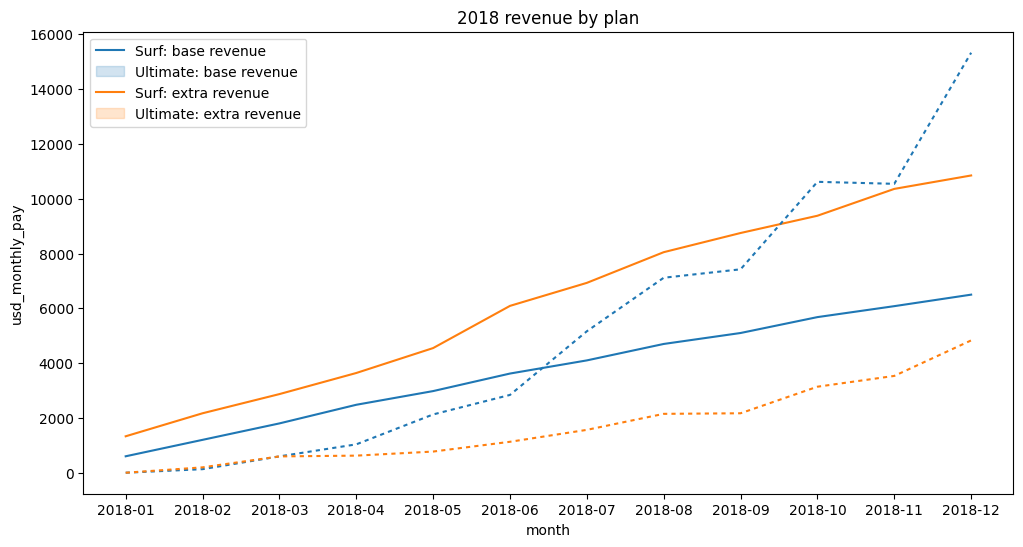

In [42]:
plt.figure(figsize=(12, 6))
plt.title('2018 revenue by plan')
sns.lineplot(data=income_by_plan, x='month', y='usd_monthly_pay', hue='plan')
sns.lineplot(data=income_by_plan, x='month', y='total_extra', hue='plan', dashes=(2, 2))

plt.legend(labels=['Surf: base revenue', 'Ultimate: base revenue', 'Surf: extra revenue', 'Ultimate: extra revenue'])


plt.show()

In [43]:
# Aggregating mean income by plan
mean_income_by_plan = pd.pivot_table(data=income_by_user, index=['plan', 'month'], values='total_revenue', aggfunc='mean')
mean_income_by_plan.columns = ['mean_revenue']
mean_income_by_plan = mean_income_by_plan.reset_index()
mean_income_by_plan

,plan,month,mean_revenue
0,surf,2018-01,20.000000
1,surf,2018-02,22.159500
2,surf,2018-03,26.629444
3,surf,2018-04,28.351048
4,surf,2018-05,34.277651
5,surf,2018-06,35.689503
6,surf,2018-07,45.188098
7,surf,2018-08,50.284468
8,surf,2018-09,49.116353
9,surf,2018-10,57.387394


##### Hypothesis testing

It was proposed that the mean income obtained from Surf and Ultimate were different. From this proposal, the null hypothesis can be written as such:

**H<sub>0</sub>: The mean income of Surf and Ultimate were equal.**

The opposing idea can be written as the alternate hypothesis:

**H<sub>a</sub>: The mean income of Surf and Ultimate were not equal.**

To test these hypotheses, I will be using the Student's two-tailed two-sample t-test with a confidence interval of 95%. The result of Levene's test as shown below (`pvalue < 0.05`) indicates that the two samples do *not* have equal variances.

In [44]:
# Calculating the difference in variance
surf_mean = mean_income_by_plan.query('plan == "surf"')['mean_revenue']
ultimate_mean = mean_income_by_plan.query('plan == "ultimate"')['mean_revenue']

results = st.levene(surf_mean, ultimate_mean)
print("p-value: " + str(results.pvalue))
if results.pvalue > 0.05:
    print('The two samples have equal variances')
elif results.pvalue < 0.05:
    print('The two samples do not have equal variances')

p-value: 0.009923083965166526
The two samples do not have equal variances


In [45]:
# t-testing
results = st.ttest_ind(surf_mean, ultimate_mean, equal_var=False)
print('p-value: ', results.pvalue)
if results.pvalue > 0.05:
    print('We reject the alternate hypothesis')
elif results.pvalue < 0.05:
    print('We reject the null hypothesis')

p-value:  7.738078421309711e-08
We reject the null hypothesis


The two-sample t-test returned a minuscule value of 7.738078421309711 * 10<sup>-8</sup>, which is far lower than the `0.05` significance level. Therefore, we **reject the null hypothesis** that the mean income of the two plans were equal.

**Findings:**
1. Similar growth trend across the year present in service usage and customer increase can be observed in income growth as well.
1. In 2018, Surf plan brought in an estimated \\$107,767, while Ultimate brought in around \\$95,673 in total income (including extra charges).
1. Extra charges for the year were totaled to around \\$62,927 and \\$20,703 for Surf and Ultimate plans, respectively.
1. The year-long average monthly income was \\$8,980 for Surf and \\$7,972 for Ultimate.

**Insights:**
1. Income increased steadily throughout 2018. This is in line with the increase in customers.
1. In 2018, Surf brought in the most income.
1. Collectively, Surf users incurred more extra charges than Ultimate users.
1. Extra charges contributed to ~65% of the total income for Surf and ~22% for Ultimate.
1. Surf's average monthly income seem to be higher than that of Ultimate's.

**Recommendations:**
Surf should be promoted more since it brought in more revenue.

#### 4. NY-NJ regional mean monthly income

The department has tasked me with comparing the mean monthly income from NY-NJ with the rest of the country. The actual region in question would be `NY-NJ-PA`.

In [46]:
# Aggregating mean income by region and month
income_by_region = pd.pivot_table(data=income_by_user, index=['is_ny_nj', 'month'], values='total_revenue', aggfunc='mean')
income_by_region.columns = ['mean_revenue']
income_by_region = income_by_region.reset_index()
income_by_region['month'] = income_by_region['month'].astype(str)
income_by_region

,is_ny_nj,month,mean_revenue
0,False,2018-01,41.250000
1,False,2018-02,42.955342
2,False,2018-03,46.744862
3,False,2018-04,45.954621
4,False,2018-05,49.716425
5,False,2018-06,52.925045
6,False,2018-07,59.952540
7,False,2018-08,63.626587
8,False,2018-09,62.070784
9,False,2018-10,69.117110


<AxesSubplot: title={'center': '2018 mean revenue by region'}, xlabel='month', ylabel='mean_revenue'>

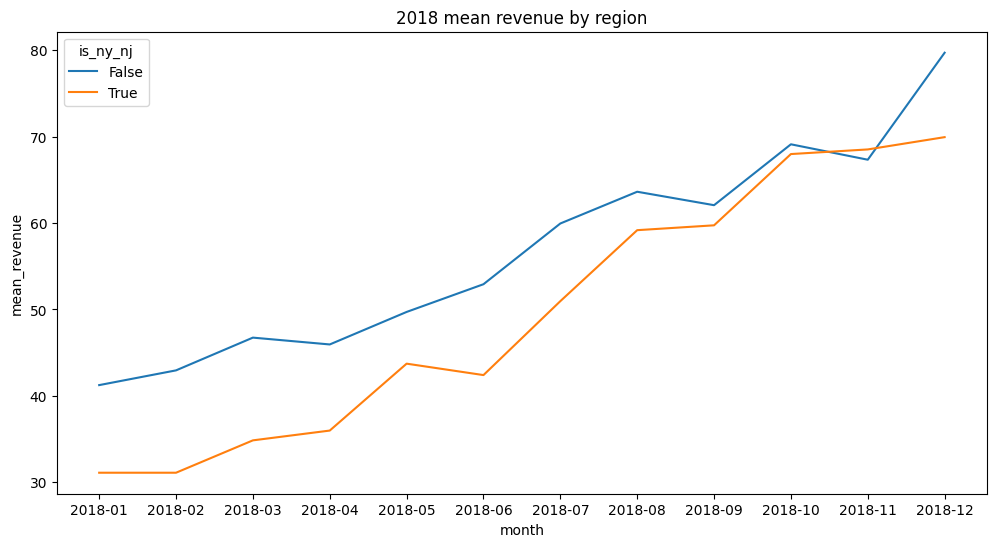

In [47]:
plt.figure(figsize=(12, 6))
plt.title('2018 mean revenue by region')
sns.lineplot(data=income_by_region, x='month', y='mean_revenue', hue='is_ny_nj')

##### Hypothesis testing

It was proposed that the mean income generated by users residing in NY-NJ and other regions were different. From this proposal, the null hypothesis can be written as such:

**H<sub>0</sub>: The mean income of users in NY-NJ and other regions were equal.**

The opposing idea can be written as the alternate hypothesis:

**H<sub>a</sub>: The mean income of users in NY-NJ and other regions were not equal.**

To test these hypotheses, I will be using the Student's two-tailed two-sample t-test with a confidence interval of 95%. The result of Levene's test as shown below (`pvalue > 0.05`) indicates that the two samples do have equal variances.

In [48]:
# Calculating the difference in variance
ny_nj_mean = income_by_region.query('is_ny_nj == True')['mean_revenue']
other_mean = income_by_region.query('is_ny_nj == False')['mean_revenue']

results = st.levene(ny_nj_mean, other_mean)
print("p-value: " + str(results.pvalue))
if results.pvalue > 0.05:
    print('The two samples have equal variances')
elif results.pvalue < 0.05:
    print('The two samples do not have equal variances')

p-value: 0.2587595088791944
The two samples have equal variances


In [52]:
# t-testing
results = st.ttest_ind(ny_nj_mean, other_mean, equal_var=True)
print('p-value: ', results.pvalue)
if results.pvalue > 0.05:
    print('We failed to reject the null hypothesis')
elif results.pvalue < 0.05:
    print('We reject the null hypothesis')

p-value:  0.21110026596155104
We failed to reject the null hypothesis


The two-sample t-test returned a value (0.21110026596155104) above the level of significance. As a result, we can safely **reject the alternate hypothesis** which states that the two mean income were not equal.

**Findings & insights:**
Although the graph shows that the two regions were somewhat apart, statistical analysis has proven that the mean revenue from NY-NJ and other regions were indeed equal.

**Recommendations:** NY-NJ doesn't need any special marketing strategy. The same advertising campaign can be carried out for every region.

## Conclusions

To achieve the project goals, I was provided with the following data:
1. `users`: users' personal information
1. `calls`: individual phone call information
1. `messages`: individual SMS message information
1. `internet`: Internet usage information by session
1. `plans`: Megaline's plan pricing details.

To facilitate further analyses, the following actions were taken in data preprocessing:
1. Conversion of dates into months as `period`-type data.
1. Conversion of `user_id` into string `object`s.
1. Removal of unnecessary `city` details and flagging of `NY-NJ` entries for later use.
1. Aggregation and rounding of service usage by month. Call seconds were rounded to the next minute and data units have been changed to gigabytes.
1. Aggregation of all relevant data into a single dataframe called `data`.
1. Removal of empty rows.
1. Calculation of extra charges incurred by service usage outside of plan allocation.

In EDA, it became clear that:
1. Revenues, along with usage and the number of customers, increased steadily throughout the year. This means that January saw the lowest revenues and income peaked in December.
1. In 2018, Surf plan brought in an estimated \\$107,767, while Ultimate brought in around \\$95,673 in total income (including extra charges).
1. Extra charges made up around ~65% and ~22% of Surf's & Ultimate's total income, respectively. This means that many Surf users would often use services outside of the allocated plan and incur extra charges.
1. The two plans generated similar mean monthly revenue.
1. Mean revenue generated by users in NY-NJ were not different from that of other regions.

From these findings and insights, the appropriate recommendations for the advertising department would be **to invest more in advertising the Surf plan to promote sales.**